# 04: Balancing and binning

## Balancing

Problem: We have an instance of some classification problem and our data set is imbalanced, that is, one class has _significantly_ less representants than another class.

In [ ]:
import numpy as np
import pandas as pd

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize_scalar

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression, RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### The data

In [ ]:
data = pd.read_csv('default_of_credit_card_clients.csv',sep=';') #Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.
data.describe() #data description: see https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [ ]:
data.info()

In [ ]:
data['class'].value_counts()

In [ ]:
class_names = [0,1] # for printing purposes later

## (Binary) classification and its evaluation

In order to evaluate the preprocessing of our data set, we shall use some classifiers as black boxes.

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

The following metrics are commonly used to evaluate the performance of a **binary** classifier (and the underlying data set).

There are 2 classes, positive and negative. The counts of their representantas are denoted $P$ and $N$, respectively.
The results of the classification are given by the following counts:
$$
TP = \text{true positive}, TN = \text{true negative}, FP = \text{false positive}, TN = \text{false negative}.
$$
(That is, $TP+FP$ samples are assigned the positive class by the selected classifier.)

These number are ofter stored in _confusion matrix_ (in Czech often "klasifikační matice"):
$$
C = \begin{pmatrix} TN & FN \\ FP & TP \end{pmatrix}.
$$

More indicators are often used, for instance:
$$
\text{Precision} = \frac{TP}{TP+FP}, \quad \text{Accuracy} = \frac{TP+TN}{P+N}.
$$

(In multiple class problem, these metrics are generalized in a straightforward manner, see for instance http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

confusion_matrix vrací ve tvaru
TN FP
FN TP

predikce

0  1

TN FP 0 realita

FN TP 1 realita



In [ ]:
# TASK 1: select a classifier above and classify `data` and calculate the confusion matrix of the result; comment the result

from sklearn.metrics import confusion_matrix # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#clf = GaussianNB()
#clf = SVC(gamma=2, C=1)
#clf = SVC(kernel="linear", C=0.025)

#clf = DecisionTreeClassifier()
clf = MLPClassifier(alpha=1)

y = list(data['class'])
X = data.drop(['class'],axis=1)
#X = X.loc[:, X.nunique() < 12]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
y_pred = clf.fit(X_train, y_train).predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)


Let's plot the confusion matrix (to have some fancy visualisation ...).

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ""
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Handling imbalanced classes

(We still focus on the binary class problem.)

The class with the majority of samples is called the **majority class**, the other is the **minority class**.

The basic strategies are
1. to under-sample the majority class (= to remove some its elements)
1. to over-sample the minority class (= to add some elements to the class)
1. do both of the above
1. do nothing

### Under-sampling


### Imbalanced-learn

http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html

`pip/pip3 install imbalanced-learn --user [--upgrade]`


http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.under_sampling.RandomUnderSampler.html

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_sample(X, y)
print(Counter(y_res))

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)
y_pred = clf.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


## Under-sampling methods

- Randon under-sampling
- Condensed nearest neighbour (CNN)
- (Wilson's) Edited Nearest Neigbour (ENN)
- Neigbourhood Cleaning Rule (NCL)
- One-side Sampling (OSS)
- Tomek Links

http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html#module-imblearn.under_sampling

#### Tomek links

Let $x$ and $y$ be two samples of distinct class.
If there is no sample $z$ such that
$$
\rm{d}(x, y) < \rm{d}(x, z) \quad \text{ or } \quad \rm{d}(y, z) < \rm{d}(x, y),
$$
where $\rm d$ is **the distance** between the two samples, we say there is a **Tomek link** between $x$ and $y$.

In other words, a Tomek’s link exists if the two samples of distinct class are the nearest neighbors of each other.
See the illustration at https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html#tomek-links

We can choose various strategies how to resample the data using Tomek links, for instance, we might remove all majority samples which are paired by the link with a minority sample.

*Question*

1. How can we visualize the removed samples if the data is multidimensional?

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

from collections import Counter

y = list(data['class'])
X = data.drop(['class'],axis=1)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=5)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)
print(X_res_vis.shape)

print(Counter(y_resampled))

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
_size = 3

# selection of PCA components
x_comp = 2
y_comp = 3

# plot
plt.scatter(X_res_vis[idx_class_0, x_comp], X_res_vis[idx_class_0, y_comp],
            alpha=.8, s=_size, label='Class #0')
plt.scatter(X_res_vis[~idx_class_0, x_comp], X_res_vis[~idx_class_0, y_comp],
            alpha=.8, s=_size, label='Class #1')
plt.scatter(X_vis[idx_samples_removed, x_comp], X_vis[idx_samples_removed, y_comp],
            alpha=.8, s=_size, label='Removed samples')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
#ax.set_xlim([-6, 6])
#ax.set_ylim([-6, 6])

plt.title('Under-sampling using random under-sampling')
plt.legend()
plt.tight_layout()
plt.show()


# Apply the tomek link undersampler
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)

print(Counter(y_resampled))

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(2, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
_size = 3

plt.scatter(X_res_vis[idx_class_0, x_comp], X_res_vis[idx_class_0, y_comp],
            alpha=.8, s=_size, label='Class #0')
plt.scatter(X_res_vis[~idx_class_0, x_comp], X_res_vis[~idx_class_0, y_comp],
            alpha=.8, s=_size, label='Class #1')
plt.scatter(X_vis[idx_samples_removed, x_comp], X_vis[idx_samples_removed, y_comp],
            alpha=.8, s=_size, label='Removed samples')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
#ax.set_xlim([-6, 6])
#ax.set_ylim([-6, 6])

plt.title('Under-sampling using Tomek links')
plt.legend()
plt.tight_layout()
plt.show()

### Over-sampling methods

- random over-sampling
- Synthetic Minority Over-sampling Technique (SMOTE)
- ...

https://imbalanced-learn.org/en/stable/api.html#module-imblearn.over_sampling

#### SMOTE

SMOTE inserts new samples based on the following idea: having selected a sample $x$ from the minority class, find its $k$ nearest neighbors, connect them and $x$ by a line, and then pick new samples ranndomly on each line.

<img src="smote.png">

https://imbalanced-learn.org/en/stable/over_sampling.html#mathematical-formulation

<!--
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/over-sampling/plot_smote.html#sphx-glr-auto-examples-over-sampling-plot-smote-py
-->

In [ ]:
from collections import Counter

from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


#clf = GaussianNB()
#clf = DecisionTreeClassifier()
clf = BernoulliNB()

y = list(data['class'])
X = data.drop(['class'],axis=1)


resamplers = [
    (RandomUnderSampler(random_state=42),'Random under-sampling'),
    (TomekLinks(random_state=42),'Tomek Links'),
    #(CondensedNearestNeighbour(random_state=42),'CNN'),
    (EditedNearestNeighbours(random_state=42),'ENN'),
    (OneSidedSelection(random_state=42),'CNN'),
    (SMOTE(random_state=42),'SMOTE'),
    (SMOTEENN(random_state=42),'SMOTEENN'),  
]

for resampler,description in resamplers:
    print(description)
    %time X_res, y_res = resampler.fit_sample(X, y)
    print(Counter(y_res))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    #plt.figure()
    #plot_confusion_matrix(cnf_matrix, classes=class_names,
    #                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    
    plt.show()



## Model validation revisited

Our validation method is very simple.
The following should/may be considered:
1. Use a cross-validation technique [homework?]
1. Use other validation metrics (this strongly depends on the task in hand) (see https://imbalanced-learn.org/en/stable/api.html#module-imblearn.metrics or https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) [see below]
1. Look deeper in what the classifier has to say ([ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), Lift etc. + AUC (Area under curve)) [see below]
1. Test the data on an raw imbalanced set [homework]
1. ...



#### ROC curve

To have a meaningful ROC curve, we need a classifier which is capable of outputting a prediction of probability that a sample is in the give class.

In [ ]:
from sklearn.metrics import roc_curve, auc

# clf = DecisionTreeClassifier()
clf = BernoulliNB()

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)

probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
#tprs.append(interp(mean_fpr, fpr, tpr))
#tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
#aucs.append(roc_auc)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC (AUC = %0.2f)' % (roc_auc),color='b', marker='x')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The dependence on the splitting of the set may be lowered by running multiple tests (in the spirit of cross-validation).

In [ ]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

# clf = DecisionTreeClassifier()
clf = BernoulliNB()

i = 0
for train, test in cv.split(X_res, y_res):
    probas_ = clf.fit(X_res[train], y_res[train]).predict_proba(X_res[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_res[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


Metrics from imbalanced learn package

http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.metrics.classification_report_imbalanced.html

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

from imblearn import over_sampling as os
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

pipeline = pl.make_pipeline(os.SMOTE(random_state=RANDOM_STATE),
                            BernoulliNB())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

## Binning

Binning is a very common discretization techique:
1. select bins $B_i$ covering (disjointly) the range of a feature $x$
1. create the discretized feature with the value $v_i$ if $x \in B_i$

Usual choices of the bins:
1. equal width (the bins have the same size)
1. equal depth (the bins contain the same number of elements)

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html

## Final remarks

### References

1. https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
1. https://svds.com/learning-imbalanced-classes/
1. [Tomas Borovicka, Marcel Jirina Jr., Pavel Kordik and Marcel Jirina, _Selecting Representative Data Sets_](https://www.intechopen.com/books/advances-in-data-mining-knowledge-discovery-and-applications/selecting-representative-data-sets)
1. [Vuk, Curk: _ROC Curve, Lift Chart and Calibration Plot_](http://www.stat.wvu.edu/~jharner/courses/dsci503/docs/vuk.pdf)
1. [Elhassan T, Aljurf M, Al-Mohanna F, and Shoukri M:_Classification of Imbalance Data using Tomek Link (T-Link) Combined with Random Under-sampling (RUS) as a Data Reduction Method_](https://pdfs.semanticscholar.org/6ec4/18f9071f3a96d5548e87e34be3665703119e.pdf?_ga=2.37521248.1702047165.1541793547-736740435.1531120151)

## Finishing the task (a.k.a homework)

Try to improve the performance of a classifier on `data` with the following conditions:

1. use binning (on features of your choice, with your choice of parameters) and comment on its effects on classification
1. use at least 2 other preprocessing techniques (your choice!) on the data set and comment the classification results
1. run all classification test at least twice - once for unbalanced original data, once for balanced data (choose a balancing technique), compare those results (give a comment)

# Init

In [6]:
import numpy as np
import pandas as pd

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize_scalar

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression, RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
import itertools

class_names = [0,1]

# taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
data = pd.read_csv('default_of_credit_card_clients.csv',sep=';') #Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.
clf = KNeighborsClassifier(3)
X = data[data.columns.tolist()[:-1]];
y = data['class']
bins = 10

## Binning
Apparently, from this video https://www.youtube.com/watch?v=HofOMf8RgjM, the number of bins should be between 5 to 10.

In [7]:
columns = data.columns.tolist()[:-1]
for column in columns:
    print("column: ", column,", uniquevals: %d"%data[column].nunique())

column:  X1 , uniquevals: 81
column:  X2 , uniquevals: 2
column:  X3 , uniquevals: 7
column:  X4 , uniquevals: 4
column:  X5 , uniquevals: 56
column:  X6 , uniquevals: 11
column:  X7 , uniquevals: 11
column:  X8 , uniquevals: 11
column:  X9 , uniquevals: 11
column:  X10 , uniquevals: 10
column:  X11 , uniquevals: 10
column:  X12 , uniquevals: 22723
column:  X13 , uniquevals: 22346
column:  X14 , uniquevals: 22026
column:  X15 , uniquevals: 21548
column:  X16 , uniquevals: 21010
column:  X17 , uniquevals: 20604
column:  X18 , uniquevals: 7943
column:  X19 , uniquevals: 7899
column:  X20 , uniquevals: 7518
column:  X21 , uniquevals: 6937
column:  X22 , uniquevals: 6897
column:  X23 , uniquevals: 6939


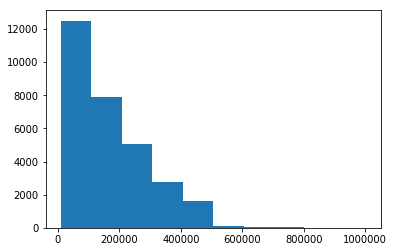

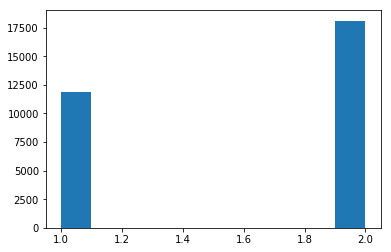

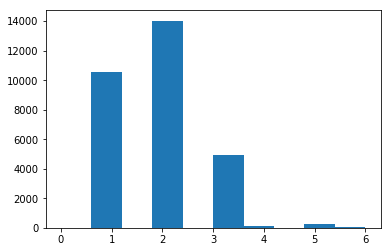

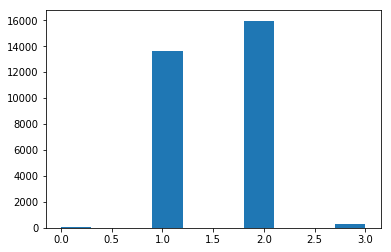

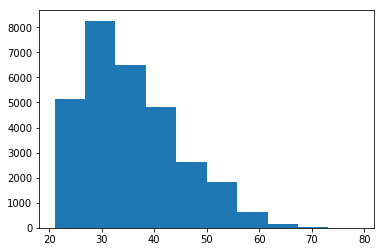

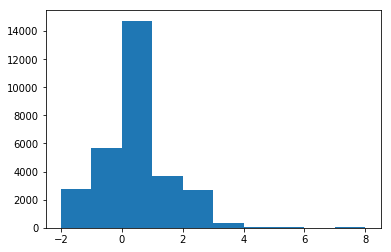

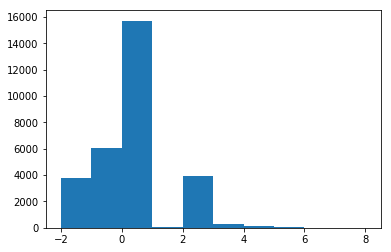

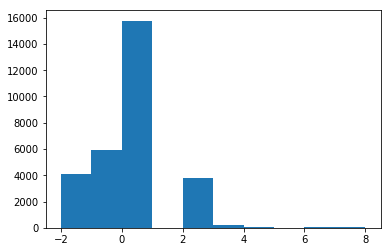

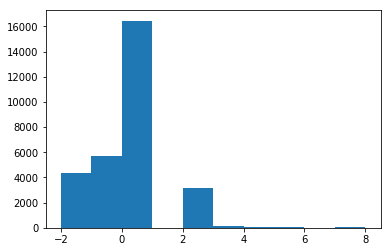

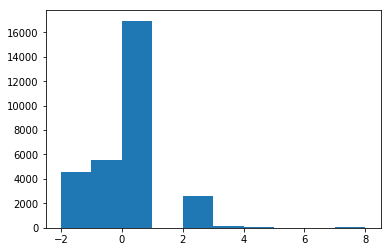

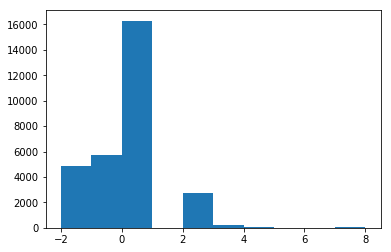

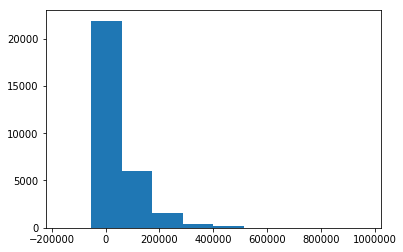

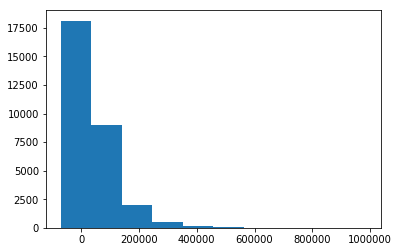

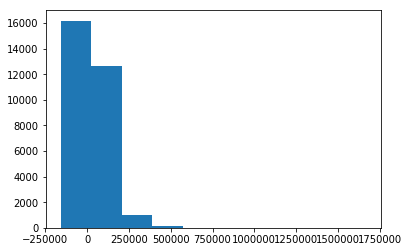

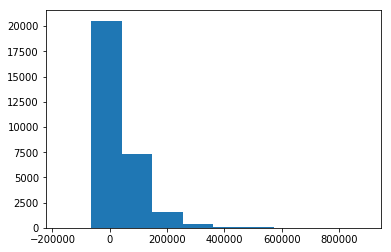

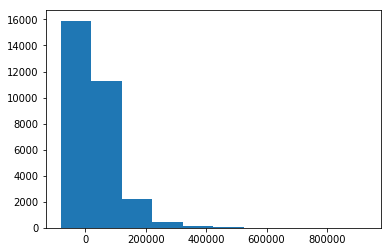

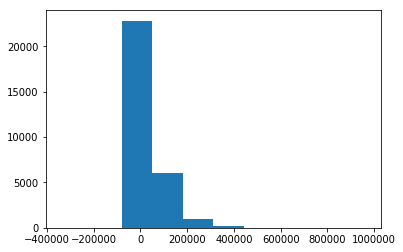

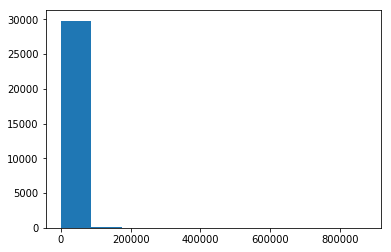

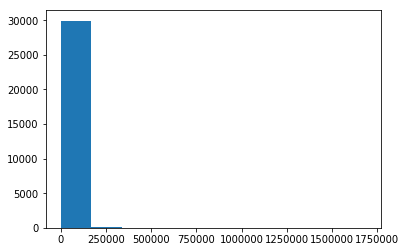

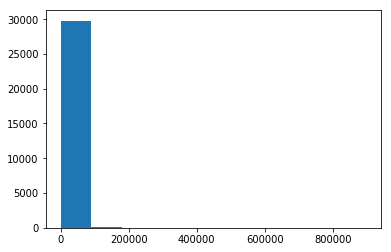

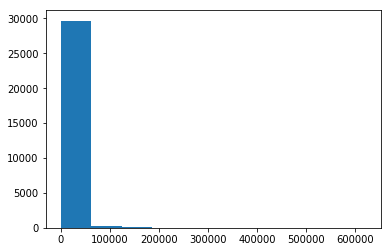

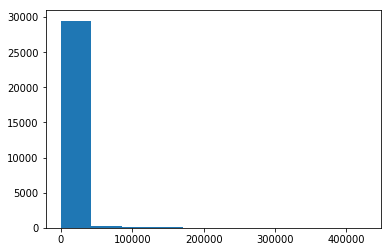

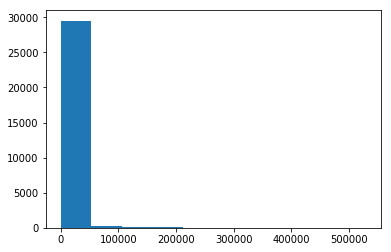

In [8]:
for column in columns:
    plt.hist(data[column])
    plt.show()

### Non-binned data

Accuracy:
0.7321666666666666


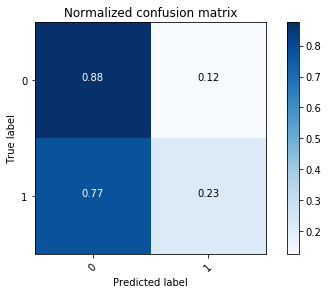

In [9]:
X = X.copy();
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
y_pred = clf.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
print("Accuracy:")
print(accuracy_score(y_test, y_pred))

### Binned data

Accuracy:
0.7321666666666666


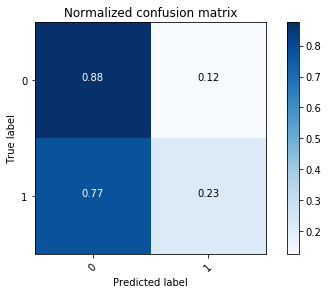

In [10]:
X_binned = X.copy();
#selectedFeatures = ['X5','X12','X13','X14','X15','X16','X17','X18','X19','X20','X21','X22','X23'] # pick features with a lot of values
#selectedFeatures = data.columns.tolist()[:-1]
#selectedFeatures = data.columns.tolist()[0:11]
selectedFeatures = ['X1','X5']
for column in selectedFeatures:
    pd.cut(X_binned[column], bins)
    #print('hi')
X_train, X_test, y_train, y_test = train_test_split(X_binned, y, test_size=.4, random_state=42)
y_pred = clf.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
print("Accuracy:")
print(accuracy_score(y_test, y_pred))

I tried different features for binning and apparently, binning has probably almost no effect on accuracy score. Maybe, I did something wrong or I was not able to figure it out, why accuracy score does not change. I read some recommendations on the Internet about binning of already discretized features. They say, the binning applied on discretized features just makes loss in given information, which may end up with lower accuracy.

## Scaling

Accuracy:
0.7768333333333334


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Accuracy:
0.774


array([[0.01, 1.  , 0.33, ..., 0.  , 0.  , 0.  ],
       [0.11, 1.  , 0.33, ..., 0.  , 0.  , 0.  ],
       [0.08, 1.  , 0.33, ..., 0.  , 0.  , 0.01],
       ...,
       [0.02, 0.  , 0.33, ..., 0.01, 0.  , 0.01],
       [0.07, 0.  , 0.5 , ..., 0.  , 0.12, 0.  ],
       [0.04, 0.  , 0.33, ..., 0.  , 0.  , 0.  ]])

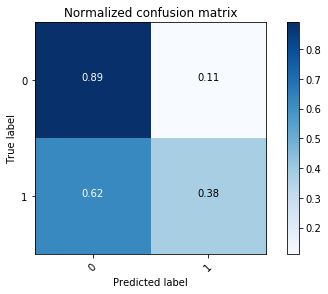

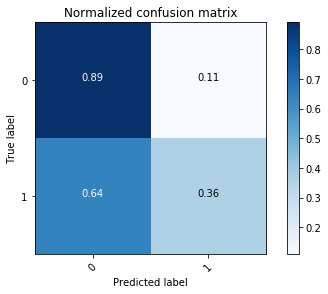

In [11]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
scalers = [MaxAbsScaler, MinMaxScaler]
for scaler in scalers:
    X_scaled = scaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.4, random_state=42)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    print("Accuracy:")
    print(accuracy_score(y_test, y_pred))
    
X_scaled

Scaling seems to be quite effective. The accurancy raised to 77 %.

## Undersampling

Accuracy:
0.5825955923902807
Accuracy:
0.8636947349110256
Accuracy:
0.7344151813425557


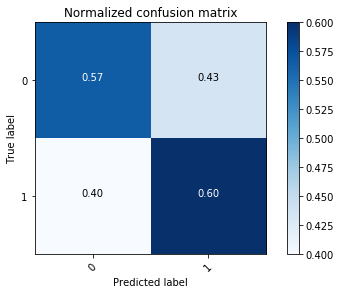

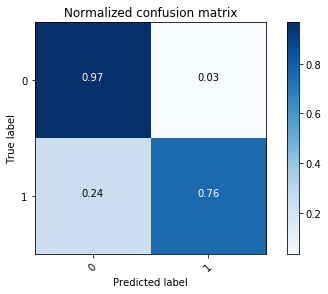

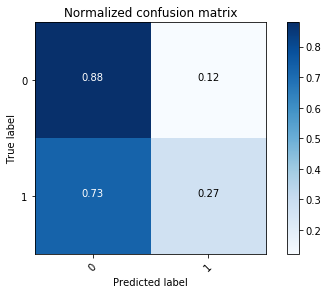

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import TomekLinks
undersamplers = [RandomUnderSampler(), RepeatedEditedNearestNeighbours(), TomekLinks(random_state=42)]

for undersampler in undersamplers:
    X_sampled, y_sampled = undersampler.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=.4, random_state=42)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    print("Accuracy:")
    print(accuracy_score(y_test, y_pred))

RepeatedEditedNearestNeighbours gives the highest accuracy score out of all tested undersampling methods. But It costs a lot of computation time in comparison to other methods.

## Undersampling and Scaling

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Accuracy:
0.8857312018946122


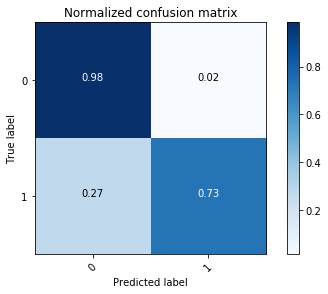

In [13]:
X_scaled = MinMaxScaler().fit_transform(X)
X_sampled, y_sampled = RepeatedEditedNearestNeighbours().fit_resample(X_scaled, y)
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=.4, random_state=42)
y_pred = clf.fit(X_train, y_train).predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
title='Normalized confusion matrix')
print("Accuracy:")
print(accuracy_score(y_test, y_pred))

So undersampling in combination with scaling gives the best accuracy, but it took much more computation time then separately.

All the used approaches are summarized in table below.

# Summary of all reached accuracies

| Binning - NO |  Binning - YES  | Scalling - MAS | Scalling - MMS | UnderSampling - RUS| UnderSampling - RENN | US - TL | UnderSampling and Scaling |
|-------|------|--------|------|-------|-------|------|------|
| 0.73216 | 0.73216 | 0.77683 | 0.774 | 0.58259 | 0.86369 | 0.73441 | 0.88573 |